# Purpose

Calculate content of mgcs scores across manually curated categories

Do for brain mgcs and PBMC mgcs

In [18]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.ticker import ScalarFormatter


# Brain mgcs content

In [19]:
# Load the mgcs dictionary
path_to_mgcs = "data/brain_mges.json"
# Load the JSON file into a dictionary
with open(path_to_mgcs, 'r') as json_file:
	mgcs= json.load(json_file)
# Convert the dictionary to a DataFrame
brain_mgcs = pd.DataFrame(list(mgcs.items()), columns=['gene', 'brainmgcs'])

In [20]:
# Load the manually curated GO terms
path_to_cur_go = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024_march/data/GOCurations.tsv"
GO_curations = pd.read_csv(path_to_cur_go, sep = "\t")
GO_curations.head()

,id,name,namespace,CTAffiliated,BrainAffiliated,PBMCAffiliated,def
0,GO:0000045,autophagosome assembly,biological_process,F,F,F,The formation of a double membrane-bounded str...
1,GO:0000070,mitotic sister chromatid segregation,biological_process,F,F,F,The cell cycle process in which replicated hom...
2,GO:0000077,DNA damage checkpoint signaling,biological_process,F,F,F,A signal transduction process that contributes...
3,GO:0000079,regulation of cyclin-dependent protein serine/...,biological_process,F,F,F,"Any process that modulates the frequency, rate..."
4,GO:0000082,G1/S transition of mitotic cell cycle,biological_process,F,F,F,The mitotic cell cycle transition by which a c...


In [21]:
# Merge the DataFrame with the dictionary DataFrame on 'id'
GO_curations = pd.merge(GO_curations, brain_mgcs, left_on='id', right_on='gene')
GO_curations.head()

,id,name,namespace,CTAffiliated,BrainAffiliated,PBMCAffiliated,def,gene,brainmgcs
0,GO:0000045,autophagosome assembly,biological_process,F,F,F,The formation of a double membrane-bounded str...,GO:0000045,0.054548
1,GO:0000070,mitotic sister chromatid segregation,biological_process,F,F,F,The cell cycle process in which replicated hom...,GO:0000070,0.012181
2,GO:0000077,DNA damage checkpoint signaling,biological_process,F,F,F,A signal transduction process that contributes...,GO:0000077,0.036833
3,GO:0000079,regulation of cyclin-dependent protein serine/...,biological_process,F,F,F,"Any process that modulates the frequency, rate...",GO:0000079,0.035272
4,GO:0000082,G1/S transition of mitotic cell cycle,biological_process,F,F,F,The mitotic cell cycle transition by which a c...,GO:0000082,0.081705


In [22]:
# Melt the CTAffiliation columns
def melt_curations(df:pd.DataFrame)->pd.DataFrame:
	"""
	create a new column that is a melted version of the GO term curations

	Parameters:
	- df: pandas DataFrame

	Returns:
	- pandas DataFrame with a new column 'meta' indicating the curation category of the GO term
	"""
	# Create a new column using conditions
	meta = df.apply(lambda row: 'Brain' if row['BrainAffiliated'] == 'T' else ('PBMC' if row['PBMCAffiliated'] == 'T' else "Neither"), axis=1)
	df['meta']=meta
	
	return df
GO_curations = melt_curations(GO_curations)
GO_curations.head()

,id,name,namespace,CTAffiliated,BrainAffiliated,PBMCAffiliated,def,gene,brainmgcs,meta
0,GO:0000045,autophagosome assembly,biological_process,F,F,F,The formation of a double membrane-bounded str...,GO:0000045,0.054548,Neither
1,GO:0000070,mitotic sister chromatid segregation,biological_process,F,F,F,The cell cycle process in which replicated hom...,GO:0000070,0.012181,Neither
2,GO:0000077,DNA damage checkpoint signaling,biological_process,F,F,F,A signal transduction process that contributes...,GO:0000077,0.036833,Neither
3,GO:0000079,regulation of cyclin-dependent protein serine/...,biological_process,F,F,F,"Any process that modulates the frequency, rate...",GO:0000079,0.035272,Neither
4,GO:0000082,G1/S transition of mitotic cell cycle,biological_process,F,F,F,The mitotic cell cycle transition by which a c...,GO:0000082,0.081705,Neither


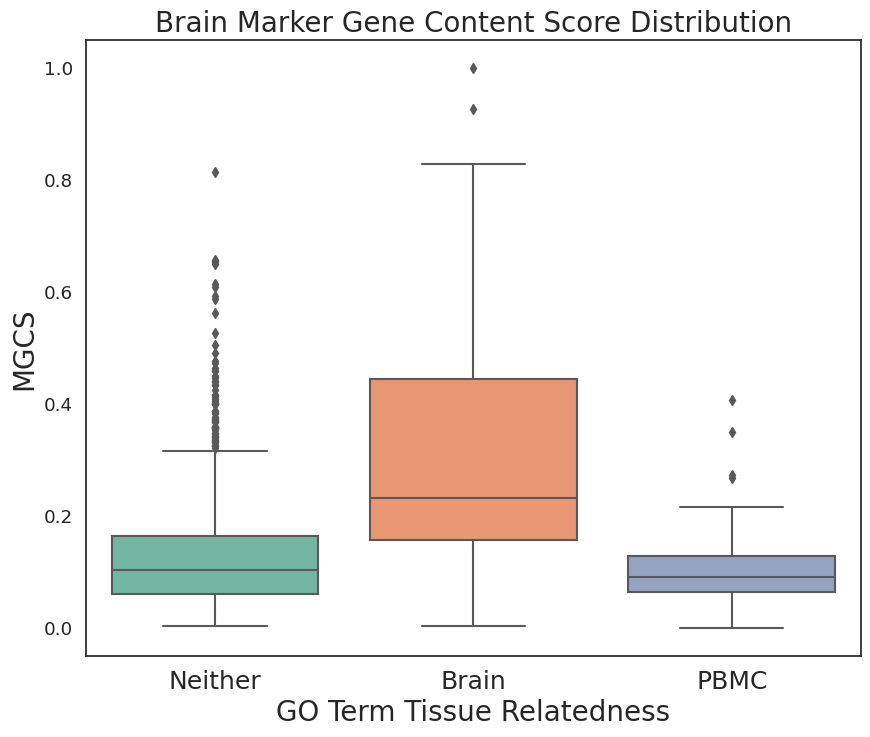

In [23]:
def plot_content(GO_curations:pd.DataFrame, ycol:str, title:str, savefig:str)->None:
    """Plot the mgcs scores across GO Term Curated categories   
    Args:
        GO_curations (pd.DataFrame): df containing info about GO term, mgcs, and curated category
        title (str): Title of plot
    """
    sns.set(style="white", font_scale=1.2)# Set up plot parameters
    plt.figure(figsize=(10, 8))  # Adjust figure size    
    # Define the custom palette
    set2_colors = sns.color_palette("Set2")
    custom_palette = {
        "Neither": set2_colors[0],
        "Brain": set2_colors[1],
        "PBMC": set2_colors[2]
}
    # Create boxplot
    g = sns.boxplot(data=GO_curations, x='meta', y=ycol, palette=custom_palette)
    # Set y-axis to log scale
    # Use ScalarFormatter to avoid scientific notation
    g.yaxis.set_major_formatter(ScalarFormatter())

    # Add titles and labels
    plt.title(title, fontsize=20)
    plt.xlabel("GO Term Tissue Relatedness", fontsize=20)
    plt.ylabel(r"MGCS", fontsize=20)  # Use LaTeX for subscript with capital L
    

    # Change x-axis tick names
    g.set_xticklabels(["Neither", "Brain", "PBMC"], fontsize = 18)  # Adjust x-axis tick labels
    # g.set_yticklabels(g.get_yticklabels(), fontsize = 16)  # Adjust x-axis tick labels

    # Saveplot
    plt.savefig(savefig, dpi = 300, bbox_inches='tight')
    plt.show()

os.makedirs('figs', exist_ok=True)
plot_content(GO_curations=GO_curations,  ycol='brainmgcs', title = "Brain Marker Gene Content Score Distribution", savefig = "figs/brain_mgcs.png")

# PBMC mgcs content

In [24]:
# Load the mgcs dictionary
path_to_mgcs = "data/pbmc_mges.json"
# Load the JSON file into a dictionary
with open(path_to_mgcs, 'r') as json_file:
	mgcs= json.load(json_file)
# Convert the dictionary to a DataFrame
pbmc_mgcs = pd.DataFrame(list(mgcs.items()), columns=['gene', 'pbmcmgcs'])

# Merge the DataFrame with the dictionary DataFrame on 'id'
GO_curations = pd.merge(GO_curations, pbmc_mgcs, left_on='id', right_on='gene')
GO_curations.head()

,id,name,namespace,CTAffiliated,BrainAffiliated,PBMCAffiliated,def,gene_x,brainmgcs,meta,gene_y,pbmcmgcs
0,GO:0000045,autophagosome assembly,biological_process,F,F,F,The formation of a double membrane-bounded str...,GO:0000045,0.054548,Neither,GO:0000045,0.007544
1,GO:0000070,mitotic sister chromatid segregation,biological_process,F,F,F,The cell cycle process in which replicated hom...,GO:0000070,0.012181,Neither,GO:0000070,0.000910
2,GO:0000077,DNA damage checkpoint signaling,biological_process,F,F,F,A signal transduction process that contributes...,GO:0000077,0.036833,Neither,GO:0000077,0.002620
3,GO:0000079,regulation of cyclin-dependent protein serine/...,biological_process,F,F,F,"Any process that modulates the frequency, rate...",GO:0000079,0.035272,Neither,GO:0000079,0.108042
4,GO:0000082,G1/S transition of mitotic cell cycle,biological_process,F,F,F,The mitotic cell cycle transition by which a c...,GO:0000082,0.081705,Neither,GO:0000082,0.013468


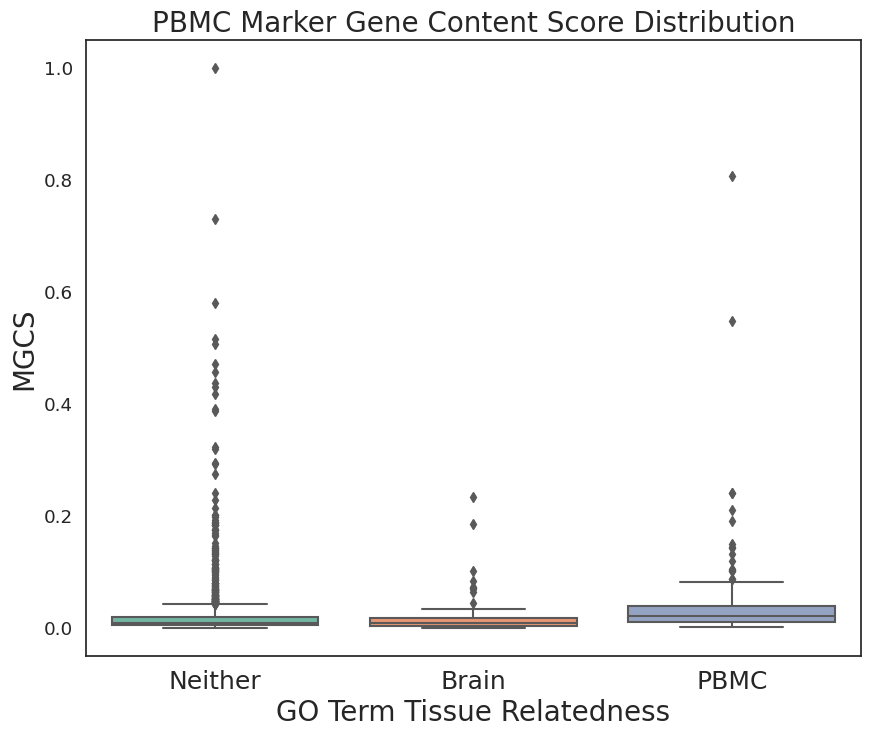

In [25]:
os.makedirs('figs', exist_ok=True)
plot_content(GO_curations=GO_curations, ycol='pbmcmgcs', title = "PBMC Marker Gene Content Score Distribution", savefig = "figs/pbmc_mgcs.png")